# Tutorial Document
This document details the use of the QCOM package. The goal is a python package that allows users to interact with Aquila and DMRG data seemlessly and prevent repetitive function writing. 

### Getting Data from DMRG files
If you have data in text files with the form

state : count

state : count

.
.
.

Then the function below allows you to easily obtain and return the data as a dictionary and additionally the total count of the values (equals 1 if the values are probabilities) using the file path as input.

This function also has a built in progress manager so you can estimate how long the data takes to load in. This is helpful for larger datasets. To track progress use the "show_progress" flag and set it equal to True. This flag is always the last parameter passed into the function call. It is set to False by default. 

Note: 

You must set the flag in the function call itself like shown below if the function has multiple arguments before show_progress. You can try for yourself but if you just do show_progress = True on a separate line and pass that into the function it will not show progress. This is because parse_file also takes in an additional two arguments, one of which (sample_size) can be represented as a boolean. Thus if you just pass file_path and show_progress with show_progress defined on a previous line, it will read show_progress as the sample size input and it will not show progress. 

### Pip install

Make sure you pip install qcom before trying the tutorial. If you haven't already running the following command in your terminal.

```bash
pip install qcom
```

Confirm that qcom has been succesfully installed and restart your jupyter before trying to import qcom.

Additionally this notebook uses matplotlib which you can install with:

```bash
pip install matplotlib
```

In [1]:
# import the qcom module

import qcom as qc
import matplotlib.pyplot as plt

In [9]:
file_path = "../example_data/1_billion_3.0_4_rungs.txt"

# Process without sampling
processed_data, total_count = qc.parse_file(file_path, show_progress = True)

# normalize the data
processed_data = qc.normalize_to_probabilities(processed_data, total_count)

print("Total count: ", total_count)

# Total after normalization
total_count = sum(processed_data.values())
print("Total count after normalization: ", round(total_count,5))

Starting: Parsing file...
Task: Parsing file | Progress: 100.00% | Elapsed: 0.00s | Remaining: 0.00s      
Completed: Parsing file. Elapsed time: 0.00 seconds.
Total count:  1000000000.0
Total count after normalization:  1.0


### Parquet files

The previous code demonstrated how to parse text files, the following code will tell you how to parse parquet files

In [12]:
file_path = "../example_data/1_billion_counts_3.0_4_rungs.parquet"

# Process without sampling

processed_data = qc.parse_parq(file_path, show_progress = True)

total_count = sum(list(processed_data.values()))
print("Total count: ", total_count)

# normalize the data
processed_data = qc.normalize_to_probabilities(processed_data, total_count)

# Total after normalization
total_count = sum(processed_data.values())
print("Total count after normalization: ", round(total_count,5))

Starting: Parsing Parquet file...
Task: Parsing Parquet file | Progress: 100.00% | Elapsed: 0.04s | Remaining: 0.00s
Completed: Parsing Parquet file. Elapsed time: 0.04 seconds.
Total count:  10000000.0
Total count after normalization:  1.0


### Most probable states
This is great but it's hard to confirm for very large datasets. To confirm the result we might just be interested in the 10 most probable states. The function below allows us to print out the n most probable states

In [13]:
n = 10
qc.print_most_probable_data(processed_data, n)

Most probable 10 bit strings:
 1.  Bit string: 01000010, Probability: 0.38929730
 2.  Bit string: 10000001, Probability: 0.38916840
 3.  Bit string: 10000010, Probability: 0.04879910
 4.  Bit string: 01000001, Probability: 0.04874300
 5.  Bit string: 00000001, Probability: 0.02059580
 6.  Bit string: 10000000, Probability: 0.02056370
 7.  Bit string: 00000010, Probability: 0.02055520
 8.  Bit string: 01000000, Probability: 0.02050380
 9.  Bit string: 10000100, Probability: 0.00499520
10.  Bit string: 00100001, Probability: 0.00497930


### Sampling 
If I want to take a random sample of the larger data into a smaller amount I can do so using the sample_data function

In [14]:
sample_size = 1000
sampled_data = qc.sample_data(processed_data, total_count, sample_size, show_progress= True)
qc.print_most_probable_data(sampled_data, 10)

Starting: Sampling data...
Task: Sampling data | Progress: 100.00% | Elapsed: 0.01s | Remaining: 0.00s     
Completed: Sampling data. Elapsed time: 0.02 seconds.
Most probable 10 bit strings:
 1.  Bit string: 10000001, Probability: 0.38400000
 2.  Bit string: 01000010, Probability: 0.37400000
 3.  Bit string: 10000010, Probability: 0.05800000
 4.  Bit string: 01000001, Probability: 0.05600000
 5.  Bit string: 10000000, Probability: 0.03000000
 6.  Bit string: 01000000, Probability: 0.02100000
 7.  Bit string: 00000010, Probability: 0.02000000
 8.  Bit string: 00000001, Probability: 0.00900000
 9.  Bit string: 01001000, Probability: 0.00800000
10.  Bit string: 11000010, Probability: 0.00500000


### Sample as you parse
It's actually more efficient to sample as we parse the set. So if you know before hand you only care about 100 randomly sample states it makes no sense to parse the whole thing and then sample it down to 100. Instead as you are parsing you will only grab 100 states. We can do this using the parse_file function by adding the sample_size parameter

In [16]:
file_path = "../example_data/1_billion_3.0_4_rungs.txt"

# Process with sampling

sample_size = 1000
processed_data, total_count = qc.parse_file(file_path, sample_size)

### Error handling
The Aquila device has a readout error rate of 0.08 for the excited state and 0.01 for the ground state. We can simulate this error on our data using the following function

NOTE: The current function assumes the default values of 0.08 and 0.01. These are taken as parameters so if future error rates change then we can accurately model those as well. Thus, you do not technically need to pass ground_rate and excited_rate into the function. Although it is good practice.

In [17]:
ground_rate = 0.01
excited_rate = 0.08

error_data = qc.introduce_error_data(sampled_data, total_count, ground_rate, excited_rate)
qc.print_most_probable_data(error_data, 10)

Introducing errors to the data...
Most probable 10 bit strings:
 1.  Bit string: 10000001, Probability: 0.07692308
 2.  Bit string: 00000010, Probability: 0.07692308
 3.  Bit string: 10000000, Probability: 0.07692308
 4.  Bit string: 01000010, Probability: 0.03846154
 5.  Bit string: 10000010, Probability: 0.03846154
 6.  Bit string: 11000010, Probability: 0.03846154
 7.  Bit string: 01000001, Probability: 0.03846154
 8.  Bit string: 01000000, Probability: 0.03846154
 9.  Bit string: 00000001, Probability: 0.03846154
10.  Bit string: 00000100, Probability: 0.03846154


### Combining data
Say you have two data sets and you want to combine them. We can do this using the following funciton, however there are some rules. You can either combine two datasets of probabilities or two datasets of counts. You cannot combine a dataset of probabilities and a dataset of counts as this would make normalizing impossible. Additionally, if you combine two probabilities, the function will automatically normalize. If you combine two datasets of counts, the function will NOT normalize. This is so if users want to combine say 100 sets of count data, they can do so without a problem. They simply need to normalize afterwards. 

In [18]:
combined_data = qc.combine_datasets(sampled_data, error_data)
print(combined_data)

{'10000100': 0.020730769230769233, '00000001': 0.023730769230769232, '01000000': 0.029730769230769234, '10010010': 0.0005, '11000010': 0.02173076923076923, '00000010': 0.048461538461538466, '01000010': 0.20623076923076922, '01100001': 0.020730769230769233, '10000000': 0.05346153846153846, '01000110': 0.019730769230769232, '00000011': 0.001, '10000011': 0.0015, '01000001': 0.04723076923076923, '11000001': 0.019730769230769232, '01000011': 0.021230769230769234, '01100010': 0.019730769230769232, '00000100': 0.019730769230769232, '00000110': 0.019730769230769232, '10000010': 0.04823076923076923, '00000000': 0.020230769230769233, '01001000': 0.023230769230769232, '00100000': 0.019730769230769232, '00100001': 0.02173076923076923, '10000110': 0.0005, '00010011': 0.019230769230769232, '00010010': 0.02173076923076923, '10000001': 0.23046153846153847}


### Saving to txt File
If we have a set of data we would like to save to a file we can do so using the following function

In [10]:
file_path = "error_data.txt"
qc.save_data(processed_data, file_path)

### Classical Info Measure

In the following we will be using the probabilities to get classical information measured about the system such as Shannon entropies, Reduced Shannon Entropies, Mutual Information, etc.

### Shannon Entropy
Let's say you have a ladder configuration of atoms with 4 rungs and you want to compute the shannon entropy of the entire dataset. You can do the following. 

NOTE: total_count is 1 by default unless otherwise specified

In [3]:
# choose a dataset
file_path = "../example_data/1_billion_3.0_4_rungs.txt"

# Load the data
processed_data, total_count = qc.parse_file(file_path, show_progress = True)

# normalize the data
processed_data = qc.normalize_to_probabilities(processed_data, total_count)

# compute the shannon entropy
total_count = 1 # we just normalized so the total count is 1
shannon_entropy = qc.compute_shannon_entropy(processed_data, total_count)
print("Shannon entropy: ", shannon_entropy)

Starting: Parsing file...
Task: Parsing file | Progress: 100.00% | Elapsed: 0.00s | Remaining: 0.00s      
Completed: Parsing file. Elapsed time: 0.00 seconds.
Shannon entropy:  1.6021996352622572


### Perhaps you want the reduced shannon entropy of just a portion of the atoms

You can define your configuration like below. The way you do your indexing depends on how you hamiltonian is constructed or how your experimental data is recorded. The convention for the 4 rung example data has indices like so 

1 3 5 7 <br>
0 2 4 6

So if I choose to have the "in" portion (portion A) have the atoms 0,1,2 and consequentily the "out" portion (portion B) be 3,4,5,6,7. The array will look like this:

A B B B <br>
A A B B 

Where A means in and B means out. In the code instead of A and B we use 1 and 0. I used letters in this example so as not to confuse you about the indexing convention.

In the code you designate your configuration with 0's and 1's and then choose a target region (0 or 1) to choose which region to obtain the reduced shannon entropy for. In the code below I want the region with the 1's so I set the target region to 1

In [20]:
# compute reduced shannon entropy on region A of processed data
configuration = [1,1,1,0,0,0,0,0]
reduced_shannon_entropy = qc.compute_reduced_shannon_entropy(processed_data, configuration, 1)
print("Reduced Shannon entropy: ", reduced_shannon_entropy)


Reduced Shannon entropy:  0.9284886172395846


Obviously I can do the opposite measure by simply flipping the target region to 0

In [21]:
# compute reduced shannon entropy on region B of processed data
configuration = [1,1,1,0,0,0,0,0]
reduced_shannon_entropy = qc.compute_reduced_shannon_entropy(processed_data, configuration, 0)
print("Reduced Shannon entropy: ", reduced_shannon_entropy)


Reduced Shannon entropy:  1.0002980229566578


### Mutual Information

The mutual information between two seperate regions A and B is defined as:

MI =  $S_{x}(A) + S_{x}(B) - S_{x}(AB)$

Where $S_x(c)$ is the shannon entropy over region c. 

You can compute this measure immedietly or you can do so in parts like previously. I will show they yield the same result.

Also note there is no target region for this code as you are compute the reduced shannon entropy of both regions regardless.

In [22]:
# compute MI between region A and B of processed data
configuration = [1,1,1,0,0,0,0,0]
mutual_information = qc.compute_mutual_information(processed_data, configuration)
print("Mutual information: ", mutual_information)

# compute the shannon entropy
shannon_entropy = qc.compute_shannon_entropy(processed_data)
print("Shannon entropy: ", shannon_entropy)

# compute reduced shannon entropy on region A of processed data
configuration = [1,1,1,0,0,0,0,0]
reduced_shannon_entropy_A = qc.compute_reduced_shannon_entropy(processed_data, configuration, 1)
print("Reduced Shannon entropy: ", reduced_shannon_entropy)

# compute reduced shannon entropy on region B of processed data
configuration = [1,1,1,0,0,0,0,0]
reduced_shannon_entropy_B = qc.compute_reduced_shannon_entropy(processed_data, configuration, 0)
print("Reduced Shannon entropy: ", reduced_shannon_entropy)

# Get MI directly from the shannon entropies

MI = reduced_shannon_entropy_A + reduced_shannon_entropy_B - shannon_entropy
print("Mutual information computed with steps: ", MI)



Mutual information:  0.3265870049339852
Shannon entropy:  1.6021996352622572
Reduced Shannon entropy:  1.0002980229566578
Reduced Shannon entropy:  1.0002980229566578
Mutual information computed with steps:  0.3265870049339852


### Conditional Entropy 

Another measure you can calculate directly is the conditional entropy over a region which is defined as:

CE(A) = $S_{x}(AB)$ - $S_{x}(B)$

You can calculate this in the code as follows:

This code assumes region A is defined by 1's and region B is defined by 0's

In [23]:
# compute the conditional entropy of region A given region B
configuration = [1,1,1,0,0,0,0,0]
conditional_entropy = qc.compute_conditional_entropy(processed_data, configuration)
print("Conditional entropy: ", conditional_entropy)

Conditional entropy:  0.6737110180226725


### Cumulative Distribution

The cumulative distribution or integrated probabilities is just a way of visualizing the state probabilities. You can do this with histograms which can be easily done with numpy, but if you want some better metrics we can do things this way. We define the cumulative sum as the following:

$\Sigma(p_{\Lambda}) = \sum_{\{n\}: p_{\{ n\}} \leq p_{\Lambda}} p_{\{ n\}} $

We can calculate this from any probability distribution with the following code:

In [24]:
# Get data from a file

file_path = "../example_data/1_billion_3.0_4_rungs.txt"
# Load the data
processed_data, total_count = qc.parse_file(file_path, show_progress = True)

# normalize the data
processed_data = qc.normalize_to_probabilities(processed_data, total_count)

# compute the cumulative sum for specific probability

probability = 1e-2
cumulative_sum = qc.cumulative_probability_at_value(processed_data, probability)
print("Cumulative sum at probability 0.5: ", cumulative_sum)

Starting: Parsing file...
Task: Parsing file | Progress: 100.00% | Elapsed: 0.01s | Remaining: 0.00s      
Completed: Parsing file. Elapsed time: 0.01 seconds.
Cumulative sum at probability 0.5:  0.041749964


### Get cumulative distribution

That was just for a specific value of p but now maybe we want to see what this looks like for all values of p. We can compute this using the following function.

Note: the following code use matplotlib, if you haven't already, make sure you pip install matplotlib in your terminal with the following:

``` bash
pip install matplotlib
```

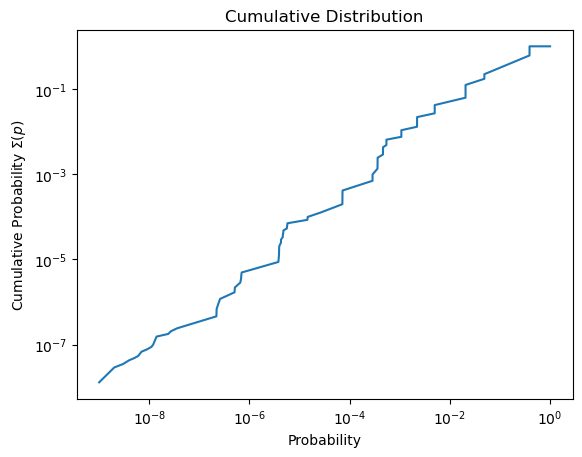

In [25]:
### import the matplotlib library
import matplotlib.pyplot as plt

### Compute the cumulative distribution for the data
x_axis, y_axis = qc.cumulative_distribution(processed_data)

### Plot the cumulative distribution
plt.plot(x_axis, y_axis)
plt.xlabel("Probability")
plt.ylabel(r"Cumulative Probability $\Sigma(p)$")
plt.title("Cumulative Distribution")
plt.xscale("log")
plt.yscale("log")
plt.show()

### Compute the Density of States

Another metric for looking at the distribution of the data is the quantity $\mathcal{N}(p)$ which we are calling "density of states." It is related to the integration probabilities like so:

\begin{equation}
\Sigma(p_{\Lambda})=\int_0^{p_{\Lambda}}dp \mathcal{N}(p)p
\end{equation}

by writing $\mathcal{N}(p)$ as a sum of delta functions weighted with possible degeneracies. 
This notation becomes useful if for $p$ small enough 
in a large enough system, we can approximate $\mathcal{N}(p)$ by a continuous function and interpret this quantity as a density of states with a probability $p$.
$\mathcal{N}(p) \Delta p \simeq $number of states with a probability between $p-\frac{\Delta p}{2}$ and $p+\frac{\Delta p}{2}$.
In addition
\begin{equation}
\Sigma(p+\frac{\Delta p}{2})-\Sigma(p-\frac{\Delta p}{2})\simeq \Delta p\mathcal{N}(p) p
\end{equation}

Solving for $\mathcal{N}(p)$ gives:

\begin{equation}
\mathcal{N}(p) \simeq \frac{1}{\Delta p \cdot p}[\Sigma(p+\frac{\Delta p}{2})-\Sigma(p-\frac{\Delta p}{2})]
\end{equation}

This function only calculate values for unique probabilities and uses $\Delta p$ = 0.1. Note that in this implementation $\Delta p$ is a logarithmic spacing. For instance if p = $10^{-30}$ then $p + \frac{\Delta p}{2} = 10^{-29.9}$ and $p - \frac{\Delta p}{2} = 10^{-30.1}$. However if p = $10^-5$ then $p + \frac{\Delta p}{2} = 10^{-4.9}$ and $p - \frac{\Delta p}{2} = 10^{-5.1}$.

<class 'dict'>
Starting: Computing N(p)...
Task: Computing N(p) | Progress: 100.00% | Elapsed: 0.14s | Remaining: 0.00s    
Completed: Computing N(p). Elapsed time: 0.14 seconds.


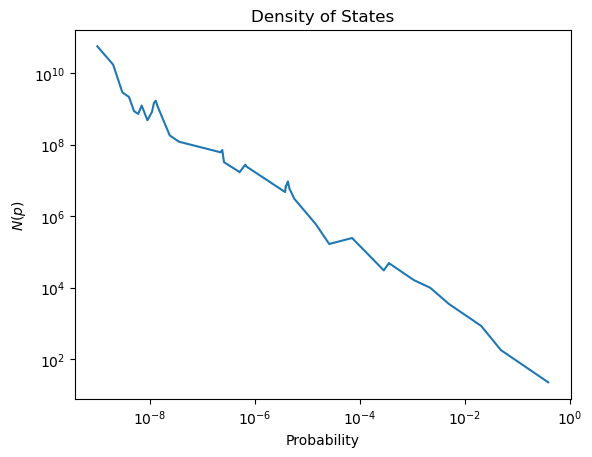

In [26]:
### Compute density of states over a the set of values

print(type(processed_data))

unique_probs, N_values = qc.compute_N_of_p_all(processed_data, p_delta = 0.1, show_progress= True)

### Plot the density of states
plt.plot(unique_probs, N_values)
plt.xlabel("Probability")
plt.ylabel(r"$N(p)$")
plt.title("Density of States")
plt.xscale("log")
plt.yscale("log")
plt.show()


### Truncating Dataset

Another thing you might be interested in doing is truncating a dataset such that you throw out all states below a certain probability. Afterwards, you then normalize your dataset to sum to 1 once more. You can do this with the following code:

In [27]:
### load the data from a file
file_path = "../example_data/1_billion_3.0_4_rungs.txt"
processed_data, total_count = qc.parse_file(file_path, show_progress = True)

### normalize the data
processed_data = qc.normalize_to_probabilities(processed_data, total_count)

### print the most probable data
n = 10
qc.print_most_probable_data(processed_data, n)

print("\nRemove states with probability < 0.01\n")

### truncate the data
truncated_data = qc.truncate_probabilities(processed_data, 0.01)

### print the most probable data
qc.print_most_probable_data(truncated_data, n)

Starting: Parsing file...
Task: Parsing file | Progress: 100.00% | Elapsed: 0.00s | Remaining: 0.00s      
Completed: Parsing file. Elapsed time: 0.00 seconds.
Most probable 10 bit strings:
 1.  Bit string: 01000010, Probability: 0.38924556
 2.  Bit string: 10000001, Probability: 0.38922358
 3.  Bit string: 01000001, Probability: 0.04877862
 4.  Bit string: 10000010, Probability: 0.04877763
 5.  Bit string: 01000000, Probability: 0.02056300
 6.  Bit string: 00000001, Probability: 0.02056146
 7.  Bit string: 00000010, Probability: 0.02055035
 8.  Bit string: 10000000, Probability: 0.02054983
 9.  Bit string: 10000100, Probability: 0.00498352
10.  Bit string: 00100001, Probability: 0.00498192

Remove states with probability < 0.01

Most probable 10 bit strings:
 1.  Bit string: 01000010, Probability: 0.40620459
 2.  Bit string: 10000001, Probability: 0.40618165
 3.  Bit string: 01000001, Probability: 0.05090386
 4.  Bit string: 10000010, Probability: 0.05090282
 5.  Bit string: 01000000,